### Supervised abalone regression

- I denne filen kommer jeg til å ta for meg trening og tuning av supervised regresjons modeller for abalone datasettet. Jeg kommer til å teste ut 3 forskjellige modeller og sammenligne hvilke av disse som prestere best.  Modellene jeg kommer til å bruke er RandomForestRegression, Ridge og Lasso.

- Siden deler av kommentarene i denne oppgaven vil være gjeldene for alle delene av oblig3 og 4 vil jeg skrive de samme eller veldig like kommentarer der hvor dette er hensiktsmessig i alle filene for disse oppgavene, men tilføre videre spesifikke kommentarer for den enkelte filen/oppgaven der hvor dette er hensiktsmessig.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import make_scorer, get_scorer

In [3]:
df = pd.read_csv(r"..\..\oblig3_og_4\abalone.data", sep=",", names=["Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [4]:
df_targets = df['Rings']
features = df.drop('Rings', axis=1)
features['Sex'] = pd.Series(np.array(LabelEncoder().fit_transform(features['Sex'])))
df_features = pd.DataFrame(StandardScaler().fit_transform(features), columns=features.columns)

In [5]:
global_random_state = 15

scoring = {
    'mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': get_scorer('r2'),
}  

def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

def train(features, targets, estimator, params, scoring=scoring, refit='r2', random_state=global_random_state, outer_splits=5, inner_splits=4):

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=global_random_state)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=global_random_state)

    scores_train = []
    scores_test = []
    estimators = []
    cv_results = []

    for (train_index, test_index) in outer_cv.split(features, targets):
        
        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise', 
            cv=inner_cv)
        grid.fit(features.iloc[train_index], targets.iloc[train_index])        
        
        evaluation_train = evaluate(grid, features.iloc[train_index], targets.iloc[train_index])
        evaluation_test = evaluate(grid, features.iloc[test_index], targets.iloc[test_index])
        
        scores_train.append(evaluation_train)
        scores_test.append(evaluation_test)
        
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))
        print("*")

    return estimators, pd.DataFrame(scores_train), pd.DataFrame(scores_test), pd.concat(cv_results, names=['test_split'], keys=range(outer_splits))

#### Beskrivelser av metoder for trening, tuning og testing av datasettet
- For å test og tune modellene har jeg laget en nested CV funksjon som bruker GridSearchCV som den indre loopen. Ut av denne funksjonen så får vi returnert den beste modellen for hver runde av den ytere loopen, de tilhørende scoring resultatene for både train og test oppsplittingen, og resultatene fra selve GridSearchCV modellen, som blant annet kan brukes til å visualisere parameter tuningen.

- Grunnen til at jeg har valgt å bruke et slik oppsett er at dette tillater meg å trene og tune modellene på hele datasettet uten at modellen overfiter til datasettet som en helhet. Dette gjør at resultatene du får ut fra denne typen tuning i større grad vil ha god overførings verdi til nye data for videre bruk.

- Måten dette oppnås på er at datasettet i yter loopen blir delt opp i for eks. 5 deler hvor du bruker 4 av disse dele til trening av modellene og den siste delen til testing. I den indre loopen splitter du igjen opp testdelen av data settet i for eks. 4 deler, hvor da 3 av disse brukes til trening av modellen og 1 del til testing/validering. På denne måte får du benyttet hele datasettet til trening og validering av modellene uten at den enkelte test delen av datasettet har blitt brukt til trening av modellen i forbindelse med sin vurdering av prestasjonen til modellen.

- Jeg har også lagt inn fuksjonalitet for å kunne endre antall spliter i ytter og inner loopene for treningen av modelene, noe som er kan være veldig nyttig for å kunne redusere kjøretiden til fuksjonen ved utprøving av forskjellige tuning parameter, noe som jeg kommer til å benytte meg av pga. eldre hardware.

- For oppdelingen av datasettet har jeg bruk StratifiedKFold slik at det oppnå så lik som mulig fordeling av target klassene mellom de forskjellige oppsplittingene av datasettet.  

- For å vurdere disse modellene har jeg valgt å bruke disse metricene "mean absolutte error", "mean squared error" og "r2". r2 er et mål på hvor mye av variasjonen i target verdiene som kan forklares av variasjonen i feature verdiene. Mean absolute error er et mål på den absolutte feil mengde for prediksjonen til modellene, og gir en indikasjon på hvor mye feil det er i prediksjonene. Mean squared error gir et bilde på hvor bra modellen håndtere eventuelle uteliggere, da feil verdier for disse blir forsterket gjennom kvadreringen i beregningen av feil marginen. 

- En ting som er hvert å merke seg for implementasjonen av Mean squared error og mean absolute error gjennom GridSearchCV er at du må bruke en negativ vurdering av denne siden disse metricene normalt sett oppgir lavere verdier som bedre og for at vurderingen i GridSearch skal fungere må disse verdiene snus slik at lavere negative verdier gir bedre resultat. Dette betyr at resultaten for disse metricene oppgir med negativ verdi, men det er bare å tolke disse som normale positive verdier da dette kun er gjort for at vuderingen av modellene skal fungere riktig.

- For å unngå eksponentiell kjøretid ved tuningen av modellene kommer jeg til å dele opp tuningen i midre deler slik at kjøretiden blir lettere håndterbar. Utover dette kommer jeg til å gjennomføre noe videre tuning og testing av modellene som ikke vil være inkludert i de endelige fila av hensyn til å gjøre dokumentet mer oversiktig og lett forstålig, men jeg kommer til å dokumentere den helheltlige prossens slik at det mulig å se en rød tråd gjennom tuningen av modellene.

-	Pga. elde hardware og problemer med lang kjøre tid på flere av modellene når disse tunes med nested cross validation vil jeg hvor det er hensiktsmessig, dele opp tuning i flere deler for å unngå eksponentiell kjøre tid. Dette er selvfølgelig ikke gunstig, da det kan være mulige påvirkende faktorer mellom tuning parametere som du ikke observere når disse tunes sekvensielt, men det dessverre nødvendig for noen av modellene. Der hvor det er mulig vil jeg heller bruke et redusert antall splitter av datasettet i kryss valideringen for å redusere kjøre tiden.

-	Etter at jeg har gjennomført tuningen av modellene kommer jeg til å kjøre en endelig test av modellene med de parameter verdiene jeg har kommet fram til. Dette gjør jeg slik GridSearchCV ikke skal velge de parameter verdiene som passer best for deler av datasettet, slik at jeg får et testresultat for de endelige modellene som er representative for hele datasettet.

-	For de avsluttende testene kommer jeg til å bruke en oppdeling av datasettet på 5 splitter for den ytre loopen og 4 for den indre. Dette gjøre at jeg vil få en god fordeling mellom training og test data og en typisk 80-20 splitt mellom traning og test i den ytre testing av datasettet.


#### RandomForestRegressor

- For å tune denne modellen så har jeg valgte å bruke disse parameterne, max_depth, min_samples_leaf, crriterion og n_estimatiors. Jeg valgte å brukes disse parameterne da jeg mener at disse er de mest relevante parameterne å bruke for denne typen modell, samt å hvis forståelse for hvordan dette påvirker prestasjonen til modellen uten at tuning og testing av modellen blir altfor tidkrevende.

- Max_depth definere hvor dype de forskjellige trene i modellen kan være, generelt vil dette gjøre at jo dypere treet er jo bedre kan disse tilpasse seg datasettet, men dette øker også risikoen for overfiting da du ofte kan få treer som tilpasser seg edge caser hvis du ikke implementere andre parameter for å unngå dette [1].

- min_samples_leaf er en parameter som brukes for å redusere overfiting på de forskjellige trærne, ved å sette en minimums begrensning på antall verdier en enkelt node i treet må inneholde. Dvs. desto mindre denne verdien er desto mer risiko for overfiting vil du få, samt at modellen lettere tilpasser seg edge caser.

- n_estimator er en parameter som definere hvor mange individuelle treere modellen kan inneholde. Dvs. desto høyere denne verdien er jo bedre kan modellen i utgangspunktet tilpasse seg et datasett, men dette øker også risikoen for overfiting samt kjøretiden til modellen [1].

- criterion er en parameter som gir deg muligheten til å velge mellom forskjellige funksjoner/algoritmer for å vurdere kvaliteten til en node split i modellen. Disse funksjonene har forskjellige styrker og svakheter som gjør at de kan være best tilpasset til forskjellige datasett [1].

- [1]: Scikit Learn. (u.å) RandomForestRegressor. Hentet 9. November 2025 fra https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html


In [ ]:
rf_params = {
    'max_depth': [5, 10, 25, 75],
    'min_samples_leaf': [2, 8, 16],
    'criterion': ['squared_error', 'poisson'],
    'n_estimators': [50, 150, 500, 1000],
}
rf_estimators, rf_scores_train, rf_scores_test, rf_cv_results = train(df_features, df_targets,
    RandomForestRegressor(random_state=global_random_state),
    rf_params, outer_splits=3, inner_splits=3)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


<Axes: xlabel='param_criterion', ylabel='mean_test_r2'>

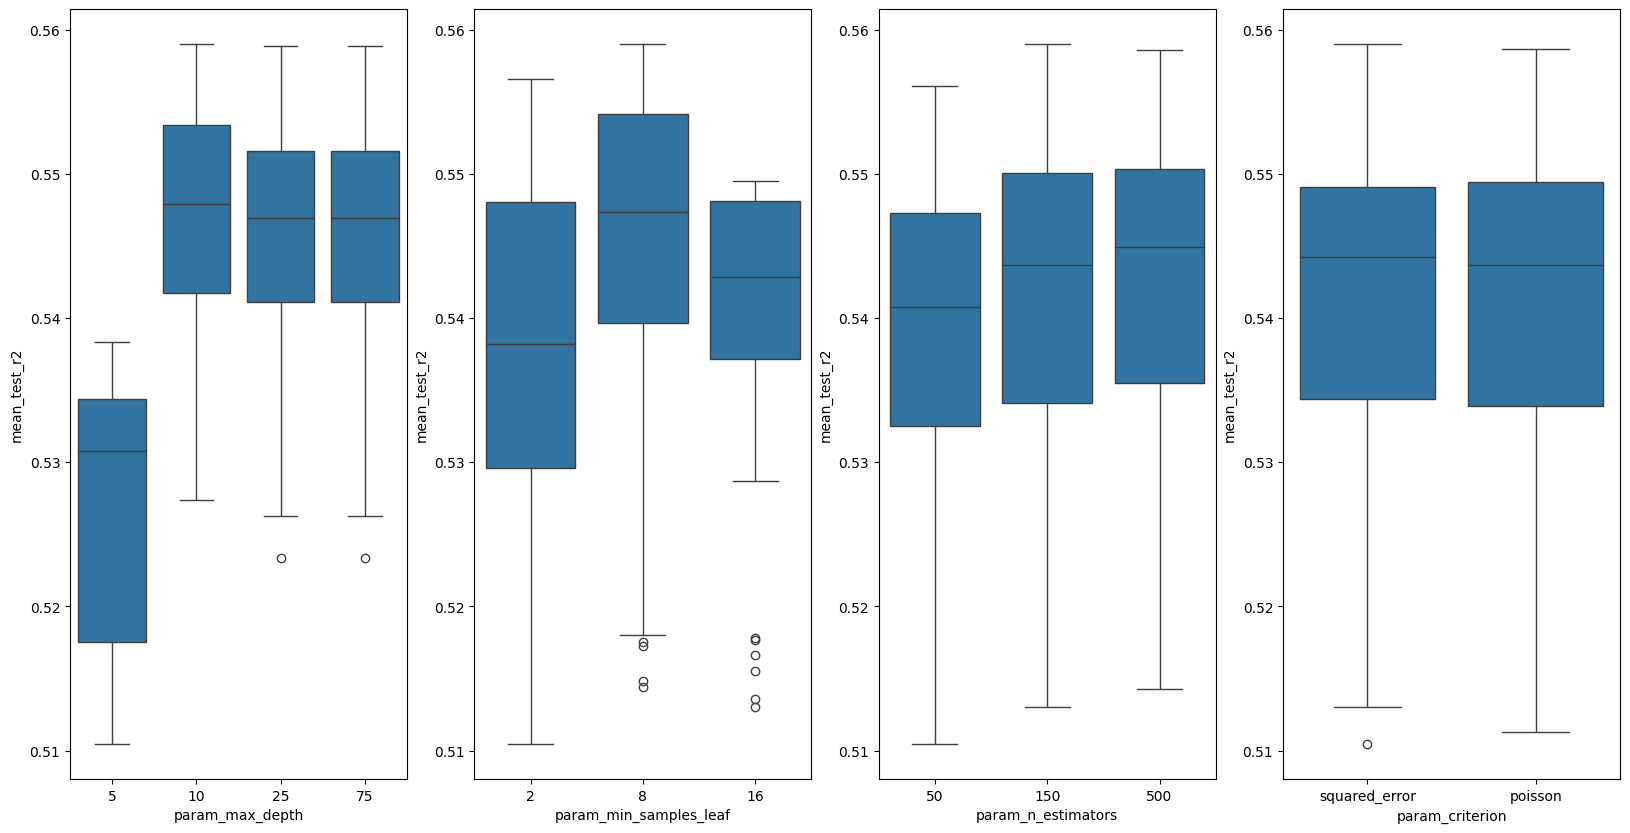

In [13]:
fig, ax = plt.subplots(1,4, figsize=(20,10))
sb.boxplot(data=rf_cv_results, x='param_max_depth', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=rf_cv_results, x='param_min_samples_leaf', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=rf_cv_results, x='param_n_estimators', y='mean_test_r2', ax=ax[2])
sb.boxplot(data=rf_cv_results, x='param_criterion', y='mean_test_r2', ax=ax[3])


-	Max_depth: For denne parameteren ser vi at en dybde på 5 gir dårligere resultater enn de andre verdiene som er testet, videre ser vi at ikke ser ut til å gi noe bedre resultater med høyere verdier enn 10 som ser ut til å gi best resultat.

-	Min_samples_leaf: For denne parameteren ser vi at 8 gir best resultater og vi ser at det er dårligere resultat for verdier til begge siden av denne verdien, derfor velger jeg å bruke denne verdien videre.

-	N_estimators: For denne parameteren ser vi at det er en stigende trend for resultatene ved høyere antall estimatorer, jeg kommer derfor til å kjøre en videre test med en høyere verdi for å sjekke om denne trenden fortsetter videre.

-	Criterion: For denne parameteren ser vi at det ikke er noen betydelig forskjell mellom de to algoritmene og der virker dermed ikke som det vil ha noen forskjell på hvilken av disse som brukes videre. Jeg velger å bruke squared_error videre i modellen.


In [14]:
rf_params = {
    'max_depth': [10, 15],
    'min_samples_leaf': [8],
    'criterion': ['squared_error'],
    'n_estimators': [500, 1000],
}

rf_estimators_2, rf_scores_train_2, rf_scores_test_2, rf_cv_results_2 = train(df_features, df_targets,
    RandomForestRegressor(random_state=global_random_state),
    rf_params, outer_splits=3, inner_splits=3)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


*


<Axes: xlabel='param_n_estimators', ylabel='mean_test_r2'>

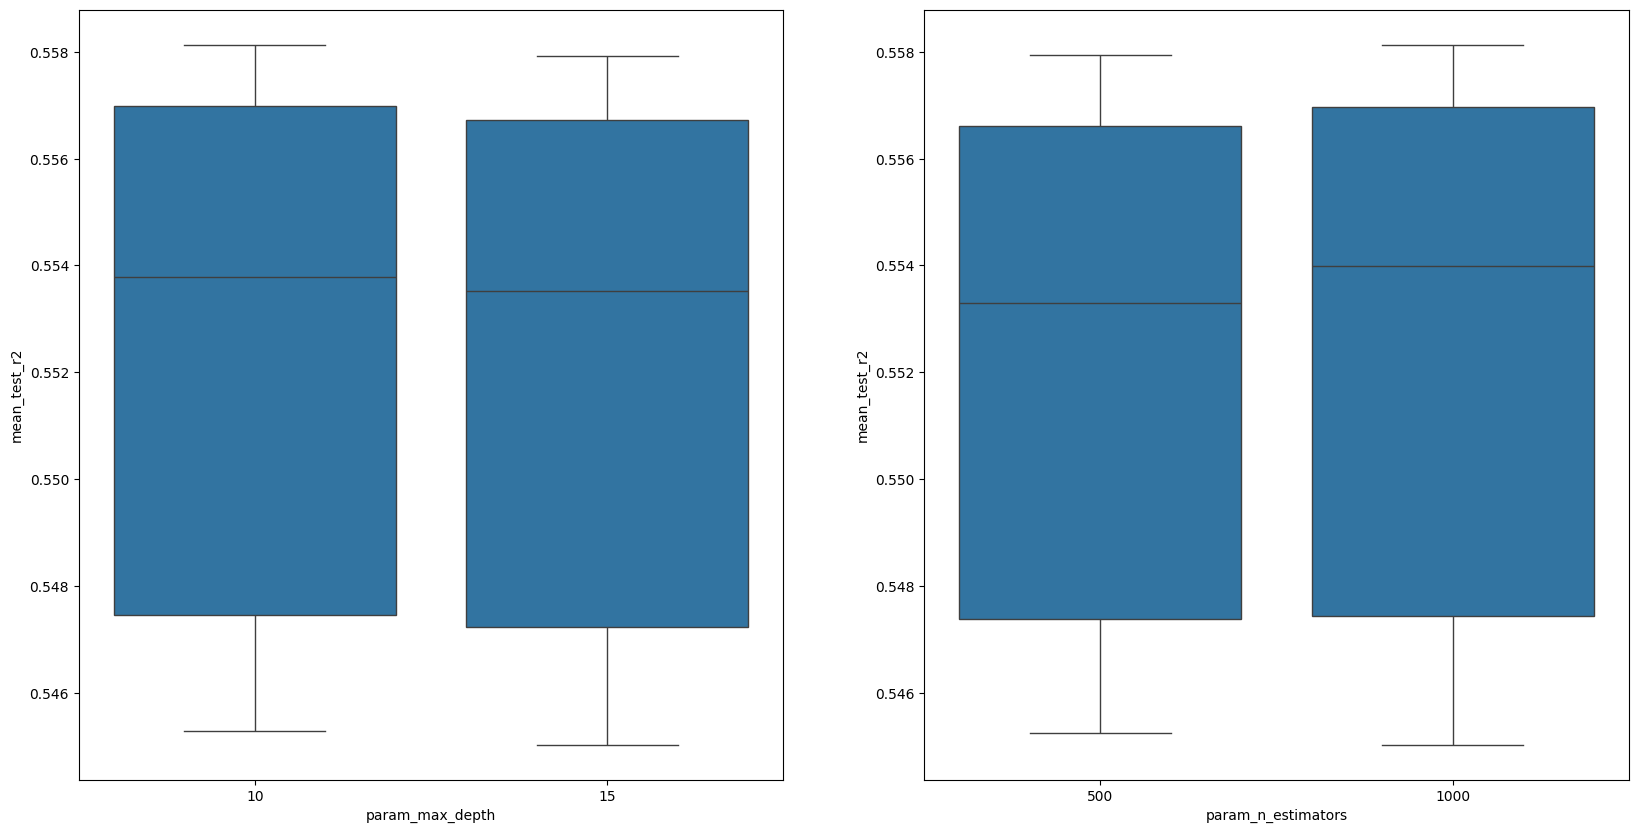

In [17]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
sb.boxplot(data=rf_cv_results_2, x='param_max_depth', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=rf_cv_results_2, x='param_n_estimators', y='mean_test_r2', ax=ax[1])

-	Max_depth: Da jeg ønsket å kjøre en videre test for antall estimatorer tok jeg også og inkluderte en test mellom 10 og 25 i for max_depth for å vurdere om det var noen videre forbedring med høyere verdier enn 10 og lavere en 25. Som vi ser av resultatene ser det ikke ut til å være noen videre forbedring og jeg beholder 10 som verdi for denne parameteren.
 
-	N_estimators: For denne parameteren ser vi at fortsatt ser ut til å være liten økning fra 500 til 1000, men denne trenden ser ut til å være avtagerne og jeg tar derfor ikke å kjøre noen videre test og bruke 1000 verdien for den endelige modellen.


In [6]:
rf_params = {
    'max_depth': [10],
    'min_samples_leaf': [8],
    'criterion': ['squared_error'],
    'n_estimators': [1000],
}

rf_estimators_final, rf_scores_train_final, rf_scores_test_final, rf_cv_results_final = train(df_features, df_targets,
    RandomForestRegressor(random_state=global_random_state),
    rf_params, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


In [9]:
rf_scores_test_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.501076,-4.561270,0.561307
std,0.017167,0.238996,0.014897
min,-1.528020,-4.939848,0.539725
25%,-1.502232,-4.610715,0.557313
50%,-1.501815,-4.498417,0.563306
75%,-1.490843,-4.456419,0.565221
max,-1.482468,-4.300950,0.580971


In [10]:
rf_scores_train_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.207375,-2.971333,0.714112
std,0.007480,0.058484,0.004330
min,-1.214710,-3.027262,0.709708
25%,-1.213757,-3.009267,0.711339
50%,-1.209276,-2.996656,0.712295
75%,-1.200922,-2.937916,0.717159
max,-1.198210,-2.885562,0.720057


#### Vurdering av RandomForestRegressor:

-	Som vi ser av verdiene for den avsluttende modellen for vi en r2 verdi på 0,561 som tilsvarer en moderat korrelasjon. Vi ser videre at std for r2 er relativt lav, dette tyder på at det ikke er store forskjeller i resultatene for de forskjellige loopene i testen.

-	Når vi sammenligner test resultatene med train, så ser vi at train har betydelig høyere verdi for r2 og lavere verdier for error verdiene. Dette tyder på at modellen har et problem med overfiting noen som ikke er uvanlig for denne typen modell.

-	Hvis vi skulle ha arbeidet videre med denne modellen ville dette vær noen som kunne vært lurt å prøve å redusere, dette kan muligens også gir oss bedre resultater totalt sett. 



#### Ridge Regression
- For denne type algoritme er det i utgangspunktet ikke en betydelig mengde med parametere som det er hensiktsmessig å tune, jeg har valg å bruke alpha, solver, max_iter og tol for trening og tuning for denne algoritmen [2].

- Alpha parameteren er i utgangspunktet den viktigste parameteren for denne algoritemen og kontrollere regulariserings stryken til modellen gjennom multiplikasjonen med L2 delen av uttrykket til linær regresjon, det er denne parameteren som gjør den algoritmen forskjellig fra standard linjer regresjon og Lasso regresjon som manipulere L1 delen av uttrykket til linjer regresjon [2].

- Solver parameteren definere forskjellige underliggende algoritmer som modellene bruker, disse har forskjellige fordeler og ulemper og gitt forskjellige karakteristikker for datasettet og gi bedre eller dårligere resultater ut ifra hvilken algoritme som er best tilpasset et datasett[2].

- max_iter parameteren lar deg sette begrensninger på antall iterasjoner som modellen får kjøre før den stopper [2].

- tol: denne parameteren er i utgangspunktet kun relevant for noen av solver parameterne og påvirker presisjonen til løsnings koeffisienten som bestemmer konvergens kriteriet for de forskjellige solver algoritmene [2].

ref[2]: Scikit Learn. (u.å) Ridge. Hentet 9. November 2025 fra https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [35]:
ridge_params = {
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'max_iter': [1000, 5000, 10000],
    'tol': [0.1, 0.01, 1e-3, 1e-4, 1e-5],
}

ridge_estimators, ridge_scores_train, ridge_scores_test, ridge_cv_results = train(df_features, df_targets,
    Ridge(random_state=global_random_state),
    ridge_params, outer_splits=5, inner_splits=4)

c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


*


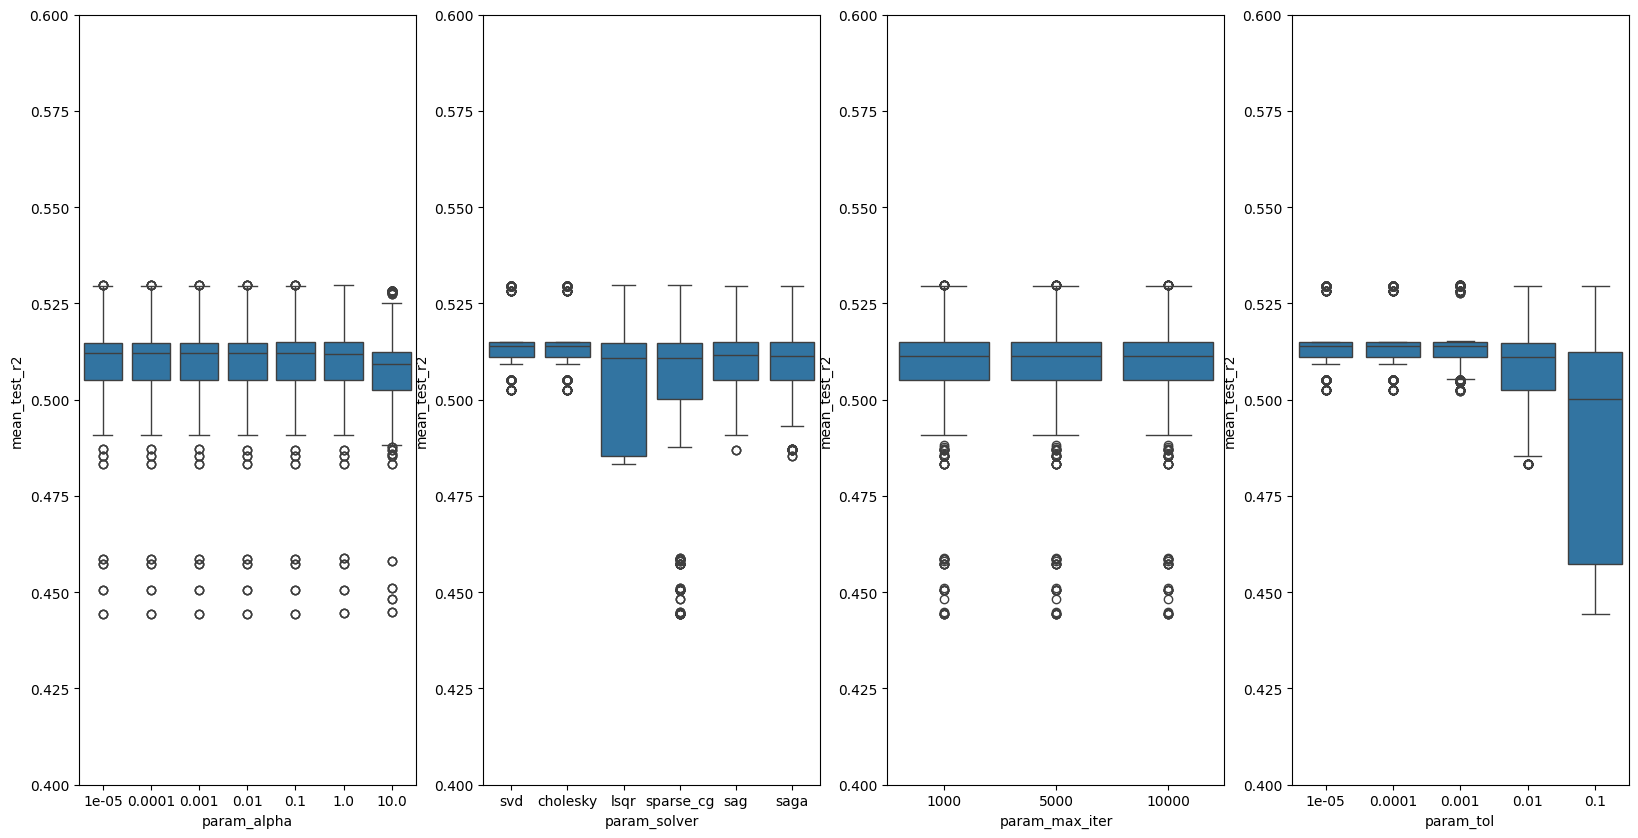

In [36]:
fig, ax = plt.subplots(1,4, figsize=(20,10))
sb.boxplot(data=ridge_cv_results, x='param_alpha', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=ridge_cv_results, x='param_solver', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=ridge_cv_results, x='param_max_iter', y='mean_test_r2', ax=ax[2])
sb.boxplot(data=ridge_cv_results, x='param_tol', y='mean_test_r2', ax=ax[3])
ax[0].set_ylim(0.4,0.6)
ax[1].set_ylim(0.4,0.6)
ax[2].set_ylim(0.4,0.6)
ax[3].set_ylim(0.4,0.6)
plt.show()

- Når vi ser på resultatene for den første runde med tuning for for Ridge, så ser vi at ikke ser ut til å være store forskjeller for de forskjellig verdiene bortsett fra et par punkter for 2 av parameterene. Jeg velger derfor å fjerne disse for å se om dette endre bilde noe. 

In [ ]:
ridge_params = {
    'alpha': [0.01, 0.1, 1],
    'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'max_iter': [250, 500, 1000],
    'tol': [1e-3, 1e-4],
}

ridge_estimators_2, ridge_scores_train_2, ridge_scores_test_2, ridge_cv_results_2 = train(df_features, df_targets,
    Ridge(random_state=global_random_state),
    ridge_params, outer_splits=5, inner_splits=4)

<Axes: xlabel='param_tol', ylabel='mean_test_r2'>

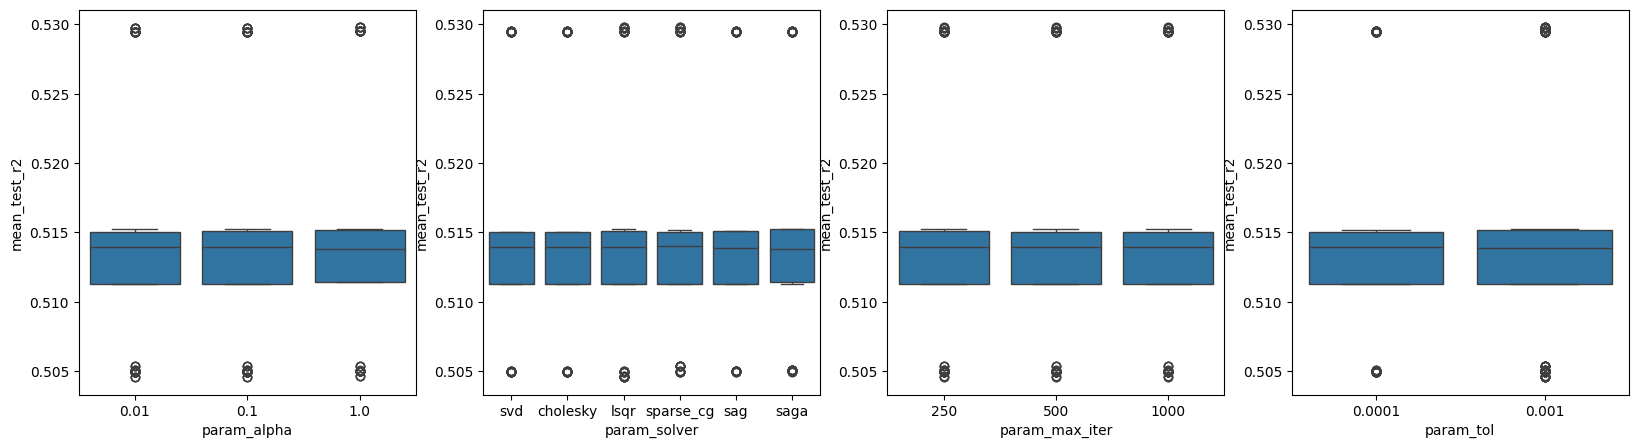

In [39]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
sb.boxplot(data=ridge_cv_results_2, x='param_alpha', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=ridge_cv_results_2, x='param_solver', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=ridge_cv_results_2, x='param_max_iter', y='mean_test_r2', ax=ax[2])
sb.boxplot(data=ridge_cv_results_2, x='param_tol', y='mean_test_r2', ax=ax[3])

- Etter at de verdiene som ga noe dårligere resultater er fjernet så ser vi at det ikke er noen forskjeller av betydning for tuning parameterene, jeg velg bare derfor bare noen verdier for den endelige modellen.

In [40]:
ridge_params = {
    'alpha': [1],
    'solver': ['lsqr'],
    'max_iter': [250],
    'tol': [1e-3],
}

ridge_estimators_final, ridge_scores_train_final, ridge_scores_test_final, ridge_cv_results_final = train(df_features, df_targets,
    Ridge(random_state=global_random_state),
    ridge_params, outer_splits=5, inner_splits=4)

*
*
*
*
*


c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\hallo\Documents\GitHub\praktisk-maskinlering\.venv\Lib\site-packages\sklear

In [41]:
ridge_scores_test_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.614761,-5.014422,0.517352
std,0.036173,0.339443,0.034383
min,-1.640502,-5.503666,0.463049
25%,-1.634086,-5.054691,0.516273
50%,-1.626870,-5.038154,0.520671
75%,-1.620935,-4.919873,0.529024
max,-1.551411,-4.555726,0.557742


In [42]:
ridge_scores_train_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.607771,-4.899299,0.528580
std,0.011163,0.061492,0.006009
min,-1.626102,-4.997583,0.520188
25%,-1.610046,-4.908742,0.526422
50%,-1.603765,-4.881482,0.529134
75%,-1.600761,-4.876889,0.530488
max,-1.598179,-4.831797,0.536667


#### Vurdering av Ridge Regression

- For denne modellen får vi en r2 verdi på 0,517 og et std for r2 på 0,034 som tyder på at modellen levere relativt jevne resulter for alle loopene i testingen.

- Når sammenligner train resultatene med test, så ser vi at det ikke er store forskjeller mellom disse vurderingen og dette viser at denne modellen ikke har noen betydelige utfordringer med overfiting. 

- Som vi ser av tuning av denne modellen gir det ikke noe store utslag meg tuning annet enn å luke bort noen verdier som gir veldig dårlige resultater for modellen.


#### Lasso Regression
- For denne modellen har jeg valg å tune disse parameterne 'alpha', 'tol' og 'max_iter'.

- Akkurat som for RidgeRegressor så er alpha den viktigste parameteren du kan tune for denne algoritmen og det som gjør det forskjellig fra linjer regresjon og ridge regresjon [3].

- tol påvirker avslutnings kriteriet til modellen og desto lavere tol er jo lavere endringer kreves det for at modellen skal avslutte [3].

- max_iter setter en begrensning på det maksimale antallet iterasjoner modellen kan kjøre [3].

ref [3]: Scikit Learn. (u.å) Lasso. Hentet 9. November 2025 fra https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [ ]:
lasso_params = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    'max_iter': [500, 1000, 5000, 10000],
}

lasso_estimators, lasso_scores_train, lasso_scores_test, lasso_cv_results = train(df_features, df_targets,
    Lasso(random_state=global_random_state),
    lasso_params, outer_splits=5, inner_splits=4)

<Axes: xlabel='param_max_iter', ylabel='mean_test_r2'>

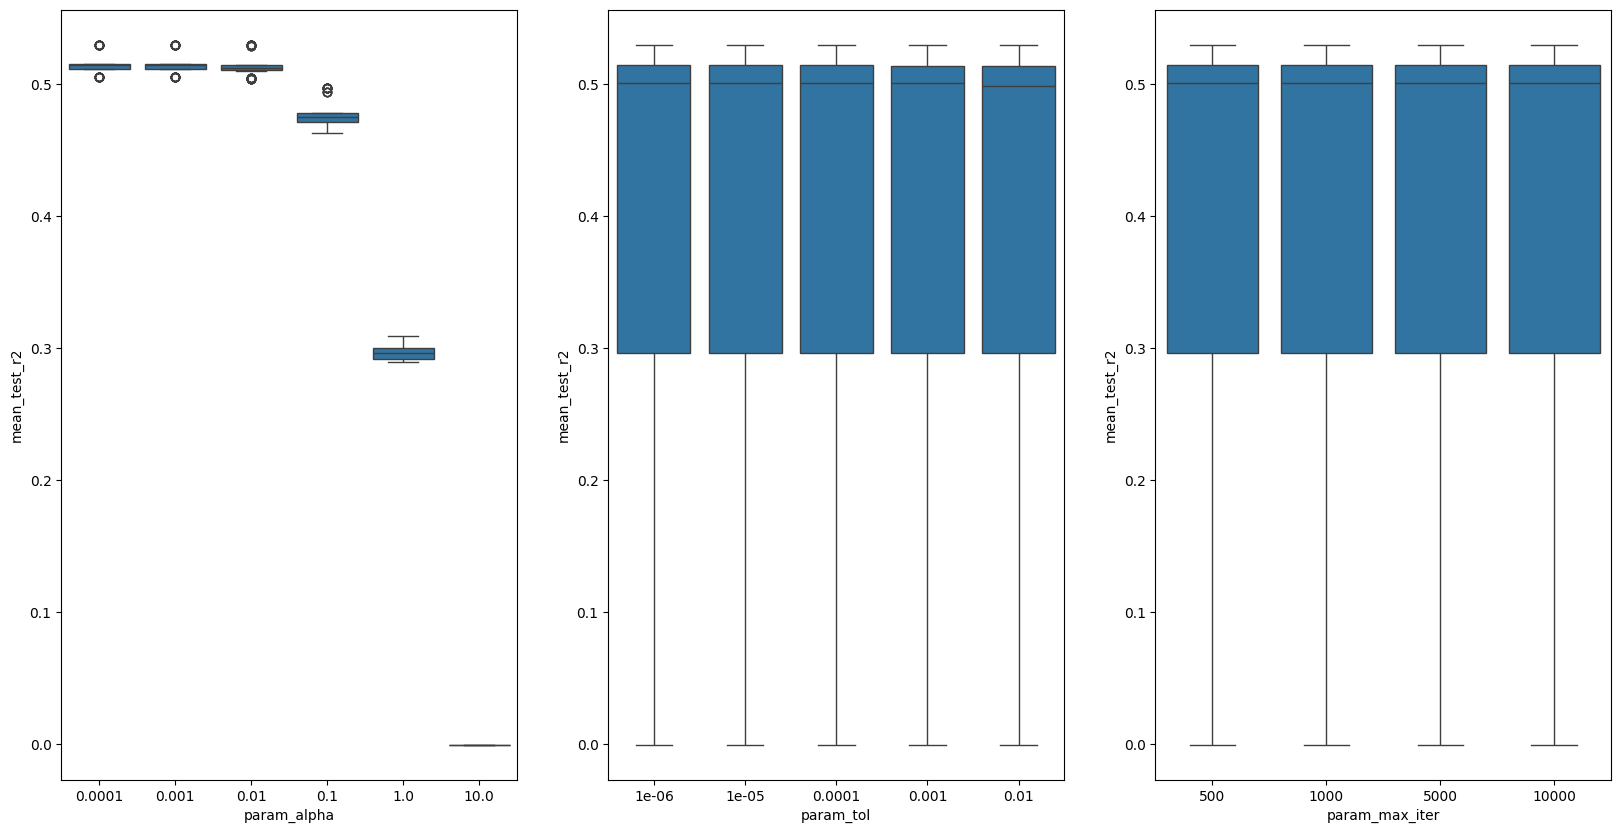

In [21]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
sb.boxplot(data=lasso_cv_results, x='param_alpha', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=lasso_cv_results, x='param_tol', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=lasso_cv_results, x='param_max_iter', y='mean_test_r2', ax=ax[2])


- Ut i fra resultatene over så ser det ut til at det kun er paramteren alpha som påvirker tuning av modellen med 2 verdier som prestere veldig dårlig kontra de andre verdiene jeg har inkludert. Jeg velger derfor å fjerne disse verdien å se hvordan modellen da prestere.

In [ ]:
lasso_params = {
    'alpha': [0.0001, 0.001, 0.01],
    'tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    'max_iter': [500, 1000, 5000, 10000],
}

lasso_estimators_2, lasso_scores_train_2, lasso_scores_test_2, lasso_cv_results_2 = train(df_features, df_targets,
    Lasso(random_state=global_random_state),
    lasso_params, outer_splits=5, inner_splits=4)

<Axes: xlabel='param_max_iter', ylabel='mean_test_r2'>

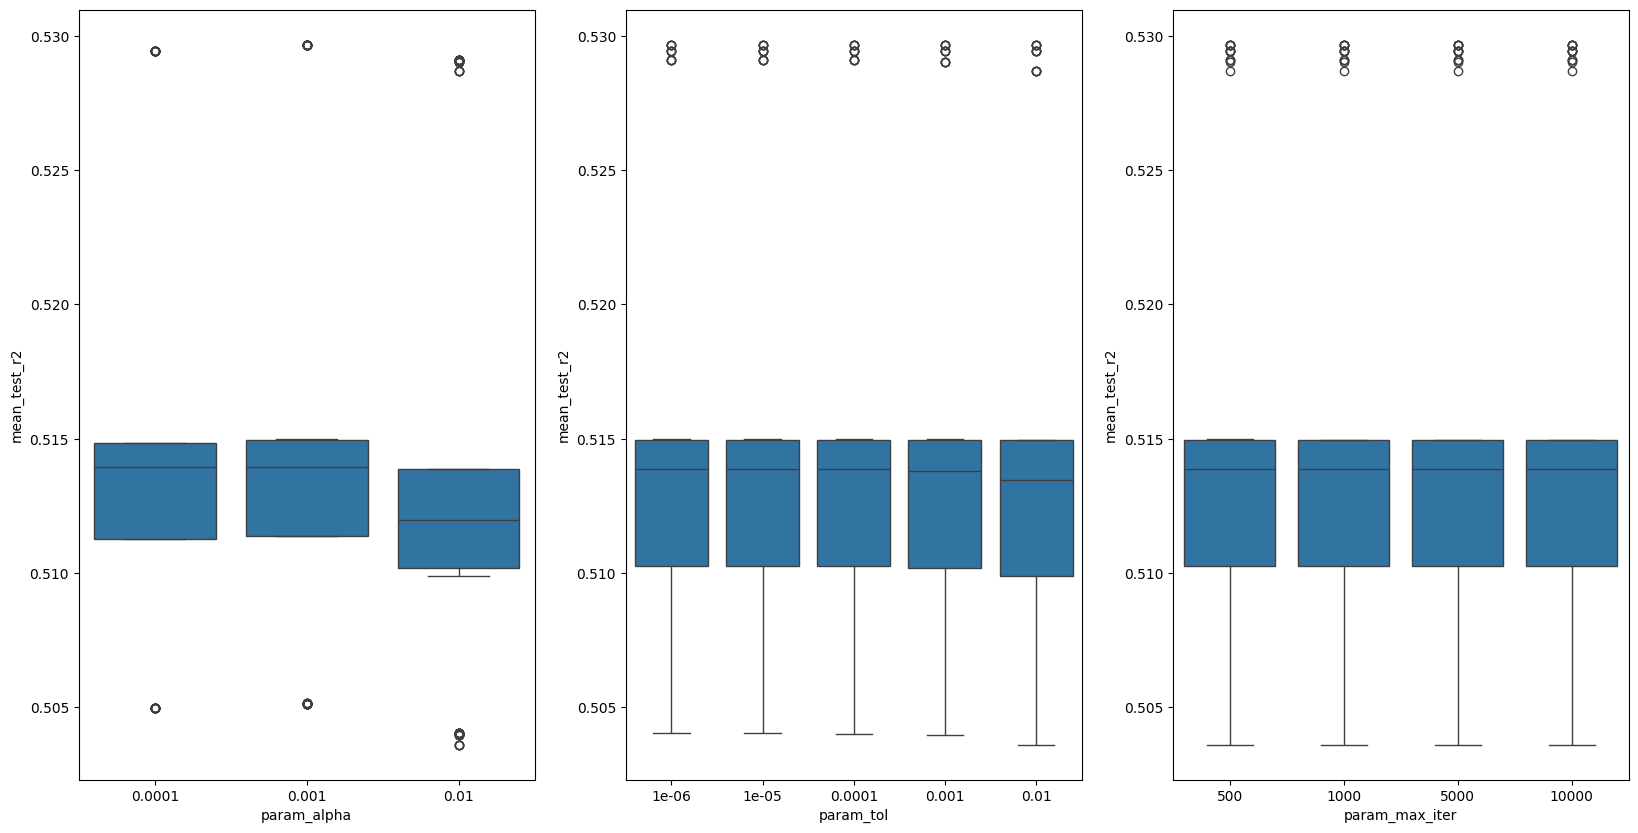

In [17]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
sb.boxplot(data=lasso_cv_results_2, x='param_alpha', y='mean_test_r2', ax=ax[0])
sb.boxplot(data=lasso_cv_results_2, x='param_tol', y='mean_test_r2', ax=ax[1])
sb.boxplot(data=lasso_cv_results_2, x='param_max_iter', y='mean_test_r2', ax=ax[2])

- Når vi ser på reulstatet for de gjenstående veriene ser at det forsatt kun er alpha parameteren som gir noe utslag ved tuning av modellen. Ut i fra verdiene som jeg har inkludert ser det ut til av lavere verdier gir best resulater, men det ser ikke ut til å være noen videre forbedring for verdier lavere enn 0.001.

- Utover en verdi på 0.001 for alpha, velger jeg en verdi på 500 for max_iter da det ikke gir noen forbedring i prestasjon med muligheten for flere iterasjoner, for tol velger jeg en verdi på 0,0001 for bruk i den avsluttende vurderingen. 

In [ ]:
lasso_params = {
    'alpha': [0.001],
    'tol': [1e-4],
    'max_iter': [500],
}

lasso_estimators_final, lasso_scores_train_final, lasso_scores_test_final, lasso_cv_results_final = train(df_features, df_targets,
    Lasso(random_state=global_random_state),
    lasso_params, outer_splits=5, inner_splits=4)

In [19]:
lasso_scores_test_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.614877,-5.013517,0.517424
std,0.035542,0.333048,0.034059
min,-1.642647,-5.501324,0.463277
25%,-1.634361,-5.036441,0.516437
50%,-1.626300,-5.034623,0.520118
75%,-1.617553,-4.925550,0.530894
max,-1.553523,-4.569648,0.556391


In [20]:
lasso_scores_train_final.describe()

,mean_absolute_error,mean_squared_error,r2
count,5.000000,5.000000,5.000000
mean,-1.607364,-4.897715,0.528733
std,0.011106,0.061642,0.006002
min,-1.625639,-4.995543,0.520384
25%,-1.609216,-4.908606,0.526720
50%,-1.603833,-4.878414,0.529147
75%,-1.600769,-4.876872,0.530490
max,-1.597363,-4.829138,0.536922


#### Vurdering Lasso Regression

- Når vi ser på resultatene for denne algoritmen så ser vi at det ikke er stor forskjeller mellom test og training delen av datasettet noe som tyder på at i likhet med rigde-modellene at modellene ikke i betydelig grad overfiter ved trening av modellene på dette datasettet. 

- Videre ser vi at test resultatene gir oss en gjennomsnittlig r2 korrelasjon på 0.517 som tyder på at modellen gir oss en moderat korrelasjon til å predikere target verdiene. Videre har vi en mean_absolute_error på 1.607, dette tyder på relativt lave feil-verdier for disse prediksjonene gitt den total rangen til target verdiene.

- Som for rigde modellen ser vi at tuning av modellen gir lite utsalg i forhold til prestasjonen av modellen annet enn og utelukke noe få mulighet som gir veldig dårlig ytelse for modellen.

In [43]:
slutt_resultat = pd.DataFrame({
    'Metric': ['Mean absolute error:','Mean squared error:','r2:'],
    'RandomForest Train': [rf_scores_train_final["mean_absolute_error"].mean(), rf_scores_train_final["mean_squared_error"].mean(), rf_scores_train_final['r2'].mean()],
    'RandomForest Test': [rf_scores_test_final["mean_absolute_error"].mean(), rf_scores_test_final["mean_squared_error"].mean(), rf_scores_test_final['r2'].mean()],
    'Ridge Train': [ridge_scores_train_final["mean_absolute_error"].mean(), ridge_scores_train_final["mean_squared_error"].mean(), ridge_scores_train_final['r2'].mean()],
    'Ridge Test': [ridge_scores_test_final["mean_absolute_error"].mean(), ridge_scores_test_final["mean_squared_error"].mean(), ridge_scores_test_final['r2'].mean()],
    'Lasso Train': [lasso_scores_train_final["mean_absolute_error"].mean(), lasso_scores_train_final["mean_squared_error"].mean(), lasso_scores_train_final['r2'].mean()],
    'Lasso Test': [lasso_scores_test_final["mean_absolute_error"].mean(), lasso_scores_test_final["mean_squared_error"].mean(), lasso_scores_test_final['r2'].mean()],
})
slutt_resultat.set_index('Metric', inplace=True)
slutt_resultat

,RandomForest Train,RandomForest Test,Ridge Train,Ridge Test,Lasso Train,Lasso Test
Metric,,,,,,
Mean absolute error:,-1.207375,-1.501076,-1.607771,-1.614761,-1.607364,-1.614877
Mean squared error:,-2.971333,-4.561270,-4.899299,-5.014422,-4.897715,-5.013517
r2:,0.714112,0.561307,0.528580,0.517352,0.528733,0.517424


### Avsluttende vurdering
 - Ut i fra totalen av resultatene så det RandomForestRegressor som gir best resultater for dette datasettet med en r2-score på 0,561, mean absolute error på 1,501 og mean squared error på 4,561. 
 
 - Dette betyr at modellen har en moderat predksjons verdi for alderen/ringene for abalonen, men en relativt lav feilmargin med en mean absolute error på 1,5 ringer noen som gir en feilverdi på ca. 5%  ut i fra total rangen til verdiene i datasettet for prediksjonene til modellen. Ut i fra en mean squared error på 4,561 ser det også ut til at modellen håndere uteligger verdier bra, men dette kan også bety at datasette i liten grad inneholder utliggerverdier som ville ført til større verdier for denne vurderingen.

 - Hvis vi ser på forskjellene for RandomForest kontra Ridge og Lasso så prestere RandomForest bedre for alle test metricene som er inkluderet, men det er ikke stor veldig forskjeller i prestasjonene mellom disse algoritmene. Det imidlertid større forskjell mellom train og test resultatene for RandomForest enn det er for Ridge og Lasso, dette tyder på at RandomForest har større utfordringer med overfiting kontra de andre to algoritmene for dette datasettet.

 - Totaltsett tyder resultatene for dette datasettet på at det kan gi prediksjoner med relativt lav feilmargin når du ser mean absolute error opp mot toalt rangen av target verdier i datasettet, men at korrelasjonen mellom feature verdiene og target verdiene ikke er så sterk. Dette var forsåvitt også påpekt i kilden til datasete, og at det muligens var behov for mere data grunnlag som tar høyde for forskjellig miljø påvirkninger for å bedre kunne estimere alder/ringer for adalonene [4].

 ref [4]: UC Irvine. (u.å) Abalone. Hentet 9. November 2025 fra https://archive.ics.uci.edu/dataset/1/abalone